## Back Test Results Binary Classification

In [1]:
import pandas as pd
from pycaret.datasets import get_data
from pycaret.classification import *
import warnings
warnings.filterwarnings('ignore')

In [2]:
dataset = pd.read_csv('Back_Test_Result.csv')
dataset.shape

(4000, 11)

In [3]:
dataset.head()

,Candle_No,Current_Market_Fit,Current_Market,Rec1_Score,Rec1_Prediction,Rec2_Score,Rec2_Prediction,Rec3_Score,Rec3_Prediction,Rec4_Score,Rec4_Prediction
0,7097.0,36.0,Bearish,89.0,BUY,25.0,BUY,12.0,SELL,76.0,SELL
1,770.0,10.0,Bullish,91.0,SELL,25.0,BUY,41.0,BUY,67.0,SELL
2,7798.0,87.0,Bullish,85.0,BUY,81.0,SELL,74.0,SELL,82.0,SELL
3,6933.0,36.0,Bullish,8.0,BUY,43.0,BUY,41.0,SELL,81.0,BUY
4,7674.0,66.0,Bearish,91.0,SELL,69.0,SELL,84.0,BUY,74.0,SELL


## Drop Predictions with Less than 20% LR Fit

In [4]:
dataset = dataset[dataset['Current_Market_Fit'] > 20]
dataset = dataset.reset_index()
del dataset['index']

In [5]:
dataset.shape

(2871, 11)

## One-Hot Encoding

In [6]:
dataset['Current_Market'] = dataset['Current_Market'].replace(['Bullish','Bearish'],[1,0])
dataset['Rec1_Prediction'] = dataset['Rec1_Prediction'].replace(['BUY','SELL'],[1,-1])
dataset['Rec2_Prediction'] = dataset['Rec2_Prediction'].replace(['BUY','SELL'],[1,-1])
dataset['Rec3_Prediction'] = dataset['Rec3_Prediction'].replace(['BUY','SELL'],[1,-1])
dataset['Rec4_Prediction'] = dataset['Rec4_Prediction'].replace(['BUY','SELL'],[1,-1])

In [7]:
dataset['Rec1_Score'] = dataset['Rec1_Score'] * dataset['Rec1_Prediction']
dataset['Rec2_Score'] = dataset['Rec2_Score'] * dataset['Rec2_Prediction']
dataset['Rec3_Score'] = dataset['Rec3_Score'] * dataset['Rec3_Prediction']
dataset['Rec4_Score'] = dataset['Rec4_Score'] * dataset['Rec4_Prediction']

In [8]:
dataset = dataset.drop([
    'Candle_No',
    'Current_Market_Fit',
    'Rec1_Prediction',
    'Rec2_Prediction',
    'Rec3_Prediction',
    'Rec4_Prediction',
], axis=1)

In [9]:
dataset.head()

,Current_Market,Rec1_Score,Rec2_Score,Rec3_Score,Rec4_Score
0,0,89.0,25.0,-12.0,-76.0
1,1,85.0,-81.0,-74.0,-82.0
2,1,8.0,43.0,-41.0,81.0
3,0,-91.0,-69.0,84.0,-74.0
4,1,-63.0,-0.0,24.0,-56.0


In [10]:
data = dataset.sample(frac=0.80, random_state=750).reset_index(drop=True)
data_unseen = dataset.drop(data.index).reset_index(drop=True)

print('Data for Modeling: ' + str(data.shape))
print('Unseen Data For Predictions: ' + str(data_unseen.shape))

Data for Modeling: (2297, 5)
Unseen Data For Predictions: (574, 5)


# Create Unseen DataFrame

In [11]:
data_unseen.head()

,Current_Market,Rec1_Score,Rec2_Score,Rec3_Score,Rec4_Score
0,1,-84.0,8.0,-22.0,49.0
1,1,31.0,-66.0,-43.0,-22.0
2,1,-85.0,-44.0,5.0,-92.0
3,0,24.0,-1.0,-63.0,-88.0
4,1,52.0,-78.0,-3.0,-44.0


In [12]:
exp_clf101 = setup(data = data, target = 'Current_Market', session_id=123, silent=True) 

,Description,Value
0,session_id,123
1,Target,Current_Market
2,Target Type,Binary
3,Label Encoded,None
4,Original Data,"(2297, 5)"
5,Missing Values,False
6,Numeric Features,4
7,Categorical Features,0
8,Ordinal Features,False
9,High Cardinality Features,False


In [13]:
compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
knn,K Neighbors Classifier,0.5345,0.5254,0.5377,0.5380,0.5375,0.0690,0.0691,0.1350
rf,Random Forest Classifier,0.5127,0.5135,0.5166,0.5176,0.5159,0.0253,0.0255,0.0500
dt,Decision Tree Classifier,0.5090,0.5089,0.5154,0.5111,0.5124,0.0178,0.0179,0.0060
et,Extra Trees Classifier,0.5071,0.5165,0.5030,0.5108,0.5057,0.0141,0.0143,0.0460
lightgbm,Light Gradient Boosting Machine,0.5047,0.5102,0.5031,0.5086,0.5039,0.0093,0.0094,0.0130
ada,Ada Boost Classifier,0.4997,0.5026,0.5475,0.5025,0.5239,-0.0014,-0.0013,0.0160
gbc,Gradient Boosting Classifier,0.4972,0.5053,0.5475,0.5001,0.5218,-0.0065,-0.0065,0.0200
svm,SVM - Linear Kernel,0.4923,0.0000,0.4735,0.4967,0.4840,-0.0151,-0.0150,0.0050
qda,Quadratic Discriminant Analysis,0.4754,0.4639,0.5946,0.4825,0.5322,-0.0509,-0.0522,0.0060
lr,Logistic Regression,0.4748,0.4650,0.5662,0.4813,0.5191,-0.0515,-0.0526,0.2530


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=-1, n_neighbors=5, p=2,
                     weights='uniform')

stop

In [14]:
MODEL = create_model('knn')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.4845,0.4629,0.4938,0.4878,0.4908,-0.0312,-0.0312
1,0.5466,0.5524,0.5926,0.5455,0.5680,0.0926,0.0930
2,0.5404,0.5253,0.5185,0.5455,0.5316,0.0810,0.0811
3,0.5714,0.5730,0.5926,0.5714,0.5818,0.1426,0.1427
4,0.5839,0.5664,0.5679,0.5897,0.5786,0.1679,0.1680
5,0.5466,0.5481,0.4938,0.5556,0.5229,0.0938,0.0944
6,0.4969,0.4824,0.4938,0.5000,0.4969,-0.0062,-0.0062
7,0.5125,0.5043,0.5432,0.5176,0.5301,0.0242,0.0243
8,0.5000,0.4845,0.5062,0.5062,0.5062,-0.0002,-0.0002
9,0.5625,0.5548,0.5750,0.5610,0.5679,0.1250,0.1250


In [15]:
TUNED_MODEL = tune_model(MODEL)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.5217,0.5264,0.6049,0.5213,0.5600,0.0425,0.0430
1,0.5652,0.5438,0.6173,0.5618,0.5882,0.1299,0.1305
2,0.4845,0.4951,0.4444,0.4865,0.4645,-0.0305,-0.0307
3,0.5528,0.5772,0.6173,0.5495,0.5814,0.1049,0.1057
4,0.4969,0.5551,0.4444,0.5000,0.4706,-0.0056,-0.0056
5,0.5280,0.5244,0.5185,0.5316,0.5250,0.0560,0.0560
6,0.5280,0.4988,0.5556,0.5294,0.5422,0.0556,0.0556
7,0.5375,0.5093,0.5679,0.5412,0.5542,0.0743,0.0744
8,0.5125,0.4810,0.5679,0.5169,0.5412,0.0236,0.0237
9,0.5812,0.5867,0.5625,0.5844,0.5732,0.1625,0.1626


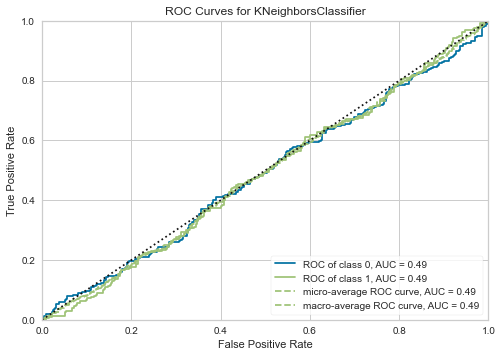

In [16]:
plot_model(TUNED_MODEL, plot = 'auc')

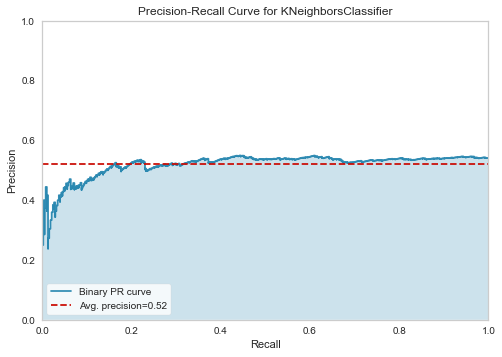

In [17]:
plot_model(TUNED_MODEL, plot = 'pr')

In [18]:
plot_model(TUNED_MODEL, plot='feature')

TypeError: Feature Importance and RFE plots not available for estimators that doesnt support coef_ or feature_importances_ attribute.

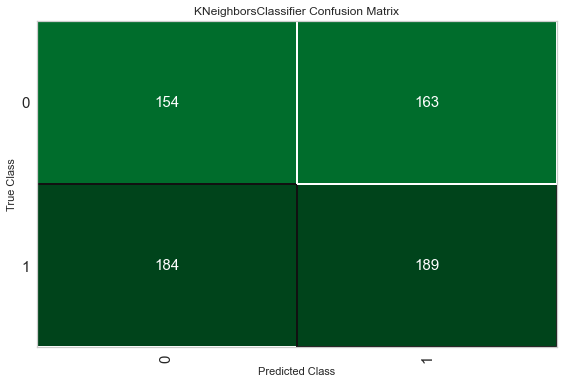

In [19]:
plot_model(TUNED_MODEL, plot = 'confusion_matrix')

In [20]:
predict_model(TUNED_MODEL);

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,K Neighbors Classifier,0.4971,0.4867,0.5067,0.5369,0.5214,-0.0075,-0.0075


In [21]:
FINAL_MODEL = finalize_model(TUNED_MODEL)

In [22]:
print(FINAL_MODEL)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='euclidean',
                     metric_params=None, n_jobs=-1, n_neighbors=12, p=2,
                     weights='distance')


In [23]:
predict_model(FINAL_MODEL);

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,K Neighbors Classifier,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000


In [24]:
unseen_predictions = predict_model(FINAL_MODEL, data=data_unseen)
unseen_predictions.head()

,Current_Market,Rec1_Score,Rec2_Score,Rec3_Score,Rec4_Score,Label,Score
0,1,-84.0,8.0,-22.0,49.0,1,1.0000
1,1,31.0,-66.0,-43.0,-22.0,1,1.0000
2,1,-85.0,-44.0,5.0,-92.0,0,0.5046
3,0,24.0,-1.0,-63.0,-88.0,0,1.0000
4,1,52.0,-78.0,-3.0,-44.0,1,1.0000


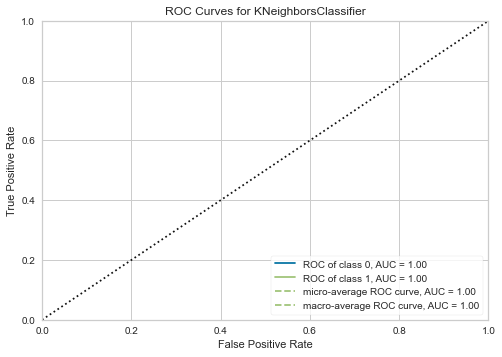

In [25]:
plot_model(FINAL_MODEL, plot = 'auc')

In [26]:
save_model(FINAL_MODEL,'FINAL_KNN_26Nov2021_EURUSD')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=None,
          steps=[('dtypes',
                  DataTypes_Auto_infer(categorical_features=[],
                                       display_types=False, features_todrop=[],
                                       id_columns=[],
                                       ml_usecase='classification',
                                       numerical_features=[],
                                       target='Current_Market',
                                       time_features=[])),
                 ('imputer',
                  Simple_Imputer(categorical_strategy='not_available',
                                 fill_value_categorical=None,
                                 fill_value_numerical=None,
                                 nume...
                 ('fix_perfect', Remove_100(target='Current_Market')),
                 ('clean_names', Clean_Colum_Names()),
                 ('feature_select', 'passthrough'), ('fix_multi', 'passthrough'),
                 ('dfs', 'p

In [27]:
SAVED_FINAL_MODEL = load_model('FINAL_KNN_26Nov2021_EURUSD')

Transformation Pipeline and Model Successfully Loaded


In [28]:
new_prediction = predict_model(SAVED_FINAL_MODEL, data=data_unseen)

In [29]:
new_prediction.head(20)

,Current_Market,Rec1_Score,Rec2_Score,Rec3_Score,Rec4_Score,Label,Score
0,1,-84.0,8.0,-22.0,49.0,1,1.0000
1,1,31.0,-66.0,-43.0,-22.0,1,1.0000
2,1,-85.0,-44.0,5.0,-92.0,0,0.5046
3,0,24.0,-1.0,-63.0,-88.0,0,1.0000
4,1,52.0,-78.0,-3.0,-44.0,1,1.0000
5,0,19.0,-3.0,-5.0,-69.0,0,1.0000
6,0,55.0,89.0,-0.0,85.0,0,0.6026
7,1,82.0,-6.0,-43.0,-0.0,1,0.8227
8,1,25.0,75.0,-18.0,38.0,1,1.0000
9,0,77.0,14.0,80.0,77.0,0,1.0000
